# Attack-CapsNet

Attack the capsule network trained on MNIST and CIFAR10 using adversarial examples.

In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import torch
from torch import optim

from datasets import get_mnist_dataset, get_cifar10_dataset, get_data_loader
from utils import *
from attacks import *

from models import *

## MNIST

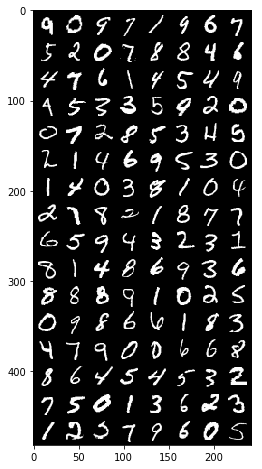

In [64]:
trainset, testset = get_mnist_dataset()
trainloader, testloader = get_data_loader(trainset, testset)
batch, labels = next(iter(trainloader))
plot_batch(batch)
batch_var = Variable(batch.cuda())
labels_var = Variable(one_hotify(labels).cuda())

In [6]:
base_model = BaselineCNN().cuda()
print(count_params(base_model))

base_loss = nn.CrossEntropyLoss()
base_optimizer = optimizer = optim.Adam(base_model.parameters())
base_trainer = Trainer(base_model, base_optimizer, base_loss,
                       trainloader, testloader, use_cuda=True,
                       print_every=50)
base_trainer.load_checkpoint('weights/baseline_mnist.pth.tar')

35445522
weights/baseline_mnist.pth.tar not found.


6804224
8215568


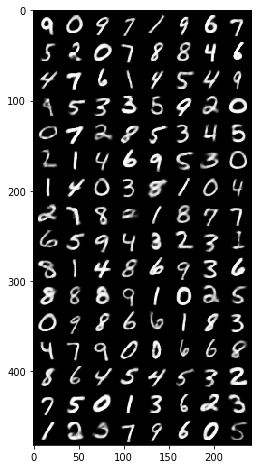

In [65]:
network = CapsuleNetwork().cuda()
decoder = CapsuleDecoder(reconstruction=True, mask_incorrect=True).cuda()
caps_model = CapsuleModel(network, decoder)

print(count_params(network))
print(count_params(caps_model))

caps_loss = CapsuleLoss(rcsn_scale=0.005)
caps_optimizer = optim.Adam(caps_model.parameters())
caps_trainer = Trainer(caps_model, caps_optimizer, caps_loss,
                       trainloader, testloader,
                       one_hot=True, use_reconstructions=True, use_cuda=True)
caps_trainer.load_checkpoint('weights/capsnet_mnist.pth.tar')
probs, batch_hat = caps_model(batch_var, Variable(one_hotify(labels).cuda()))
plot_batch(batch_hat.data)

In [155]:
# class to extract the probabilities only from capsule network
# speeds up adversarial example generation
class CapsuleProbs(nn.Module):
    
    def __init__(self, caps_net):
        super().__init__()
        self.caps_net = caps_net

    def forward(self, x):
        d_caps = self.caps_net(x)
        logits = torch.norm(d_caps, dim=-1)
        return F.softmax(logits, 1)

In [162]:
seed_ind = 34
seed_img = batch[seed_ind][None, ...]
seed_label = labels[seed_ind]

In [163]:
caps_logits = CapsuleLogits(network)
caps_adversary = Adversary(caps_logits)
fool_img = caps_adversary.generate_example(seed_img.cuda(), attack='FGS',
                                           target=None, ground=seed_label, eta=0.001, n_iters=300)

success after 84 iters


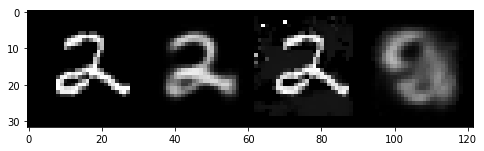

{'mse_seed': 21.51761817932129, 'mse_fool': 51.71751022338867, 'pred_fool': 8, 'pred_seed': 2}


In [164]:
results, reconstructions = evaluate_example(seed_img, fool_img, caps_model)
rec_seed, rec_fool = reconstructions['rec_seed'], reconstructions['rec_fool']
plot_batch(torch.cat([seed_img, rec_seed, fool_img, rec_fool]))
print(results)

## CIFAR10

Files already downloaded and verified
Files already downloaded and verified


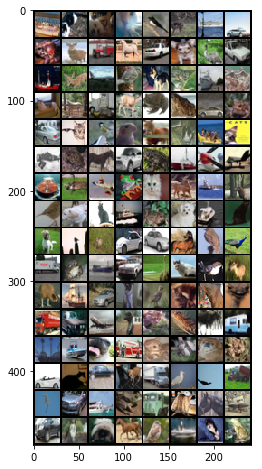

In [3]:
trainset, testset = get_cifar10_dataset()
trainloader, testloader = get_data_loader(trainset, testset)
batch, labels = next(iter(trainloader))
plot_batch(batch)
batch_var = Variable(batch.cuda())
labels_var = Variable(one_hotify(labels).cuda())

In [11]:
base_model = BaselineCNN().cuda()
print(count_params(base_model))

base_loss = nn.CrossEntropyLoss()
base_optimizer = optimizer = optim.Adam(base_model.parameters())
base_trainer = Trainer(base_model, base_optimizer, base_loss,
                       trainloader, testloader, use_cuda=True,
                       print_every=50)
base_trainer.load_checkpoint('weights/baseline_mnist.pth.tar')

35445522
weights/baseline_mnist.pth.tar not found.


13628928
16647472


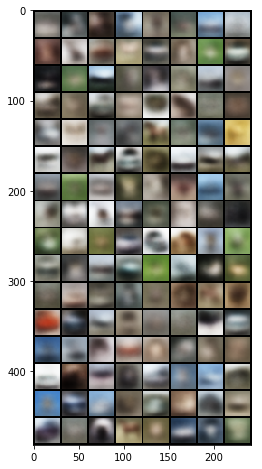

In [4]:
network = CapsuleNetwork(img_colors=3, p_caps=64).cuda()
decoder = CapsuleDecoder(img_colors=3, reconstruction=True, mask_incorrect=True).cuda()
caps_model = CapsuleModel(network, decoder)

print(count_params(network))
print(count_params(caps_model))

caps_loss = CapsuleLoss(rcsn_scale=0.001)
caps_optimizer = optim.Adam(caps_model.parameters(), lr=5e-3)
caps_trainer = Trainer(caps_model, caps_optimizer, caps_loss,
                       trainloader, testloader,
                       one_hot=True, use_reconstructions=True, use_cuda=True,
                       print_every=50)
caps_trainer.load_checkpoint('weights/capsnet_cifar.pth.tar')
probs, batch_hat = caps_model(batch_var, Variable(one_hotify(labels).cuda()))
plot_batch(batch_hat.data)

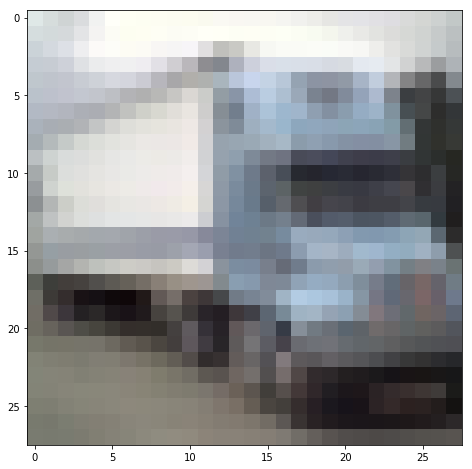

9


In [58]:
seed_img = batch[-20][None, ...]
seed_label = labels[-20]
plot_tensor(seed_img)
print(seed_label)

In [62]:
from attacks import Adversary
import torch.nn.functional as F

class CapsuleLogits(nn.Module):
    
    def __init__(self, caps_net):
        super().__init__()
        self.caps_net = caps_net

    def forward(self, x):
        d_caps = self.caps_net(x)
        logits = torch.norm(d_caps, dim=-1)
        return F.softmax(logits, 1)

caps_logits = CapsuleLogits(network)
caps_adversary = Adversary(caps_logits)
fool_img = caps_adversary.generate_example(seed_img.cuda(), attack='FGS',
                                           target=4, ground=9, eta=0.0005, n_iters=200)

success after 100 iters



 0.1030  0.1145  0.0780  0.0767  0.0787  0.0762  0.0771  0.0764  0.1161  0.2033
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]


 0.0956  0.0890  0.0713  0.0683  0.1732  0.0669  0.0691  0.0670  0.1269  0.1725
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]

{'ground_truth': 'truck', 'pred_fool': 'deer', 'pred_seed': 'truck'}


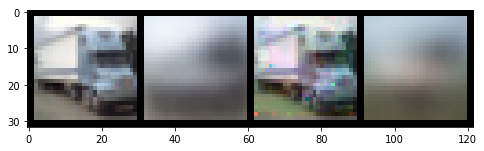

In [63]:
probs_seed, rec_seed = caps_model(Variable(seed_img).cuda())
probs_fool, rec_fool = caps_model(Variable(fool_img).cuda())
probs_seed = probs_seed.data
probs_fool = probs_fool.data
rec_seed = rec_seed.data.cpu()
rec_fool = rec_fool.data.cpu()
pred_seed = probs_seed.max(1)[1][0]
pred_fool = probs_fool.max(1)[1][0]

print(probs_seed)
print(probs_fool)
classes = {
    'ground_truth': CIFAR10_CLASSES[seed_label],
    'pred_seed': CIFAR10_CLASSES[pred_seed],
    'pred_fool': CIFAR10_CLASSES[pred_fool]}
print(classes)

plot_batch(torch.cat([seed_img, rec_seed, fool_img, rec_fool]))

In [44]:
caps_logits = CapsuleLogits(net)
caps_adversary = Adversary(caps_logits)
fool_img = caps_adversary.generate_example(seed_img.cuda(), attack='FGS',
                                           target=2, ground=8, eta=0.0002, n_iters=1000)

In [87]:
base_adversary = Adversary(base_model)
fool_img = base_adversary.generate_example(seed_img.cuda(), attack='FGS',
                                           target=2, ground=8, eta=0.00005, n_iters=10000)

In [71]:
tiny_adversary = Adversary(tiny_model)
fool_img = tiny_adversary.generate_example(seed_img.cuda(), attack='FGS',
                                           target=None, ground=8, eta=0.0002, n_iters=2000)

In [75]:
probs_seed = tiny_model(Variable(seed_img).cuda())
probs_fool = tiny_model(Variable(fool_img).cuda())
print(probs_seed.data.cpu().numpy())
print(probs_fool.data.cpu().numpy())

probs_seed = base_model(Variable(seed_img).cuda())
probs_fool = base_model(Variable(fool_img).cuda())
print(probs_seed.data.cpu().numpy())
print(probs_fool.data.cpu().numpy())

[[ -1.0639179  -5.500822    1.1167443   4.3614616  -5.531336   -3.6035335
   -5.7011847 -11.295701   17.544317    1.520819 ]]
[[-3.0111709 -6.4659963  5.892588   1.3561507  2.7954953 -7.777596
  -5.072394  -6.232225  14.467915   0.6591921]]
[[-0.10174463 -1.3642561  -0.18236588 -0.99546623 -5.263164   -2.3804703
  -1.8678036  -2.843044    8.951306   -2.459402  ]]
[[-2.0146356  -0.73223084  7.1779594   2.1735854  -3.1366234  -6.1903844
  -2.6100397  -0.7889816   1.0118126  -3.1610057 ]]


Variable containing:
 0.0854  0.0858  0.0854  0.0854  0.0854  0.0855  0.0855  0.0854  0.2309  0.0854
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]

Variable containing:
 0.0930  0.0921  0.1362  0.0924  0.0928  0.0967  0.0924  0.0936  0.1181  0.0926
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]



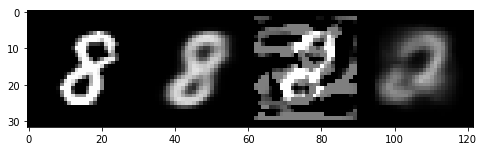

In [88]:
probs_seed, rec_seed = caps_model(Variable(seed_img).cuda())
probs_fool, rec_fool = caps_model(Variable(fool_img).cuda())
rec_seed = rec_seed.data.cpu()
rec_fool = rec_fool.data.cpu()

print(probs_seed)
print(probs_fool)
plot_batch(torch.cat([seed_img, rec_seed, fool_img, rec_fool]))

### References

[1] https://arxiv.org/abs/1710.09829